# 特異スペクトル分解(SST)と異常値判定

In [2]:
import os
import sys
import time
from itertools import islice


%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
import glob
import numpy as np
import scipy as sp
import pandas as pd


plt.style.use('seaborn-whitegrid')

In [3]:
# SSA 用の関数
def window(seq, n):
    """
    window 関数で要素を1づつずらした2次元配列を出す. 戻り値は generator
    """
    "Returns a sliding window (of width n) over data from the iterable"
    "   s -> (s0,s1,...s[n-1]), (s1,s2,...,sn), ...                   "
    it = iter(seq)
    result = tuple(islice(it, n))
    if len(result) == n:
        yield result
    for elem in it:
        result = result[1:] + (elem,)
        yield result

In [4]:
def SSA_anom(test, traject, w, ncol_t, ncol_h, ns_t, ns_h,
             normalize=False):
    """
    特異スペクトル分析 (SSA) による時系列の特徴づけ
    ARGUMENTS:
    -------------------------------------------------
    test: array-like. テスト行列を作る部分時系列
    tracject: array-like. 履歴行列を作る部分時系列
    ns_h: 履歴行列から取り出す特異ベクトルの数
    ns_t: テスト行列から取り出す特異ベクトルの数
    -------------------------------------------------
    RETURNS:
    3要素のタプル: 
        要素1: 2つの部分時系列を比較して求めた異常度
        要素2, 3: テスト行列・履歴行列をそれぞれの特異値の累積寄与率 
    """
    H_test = np.array(
        tuple(x[:ncol_t] for x in window(test, w))[:w]
    )  # test matrix
    H_hist = np.array(
        tuple(x[:ncol_h] for x in window(traject, w))[:w]
    )  # trajectory matrix
    if normalize:
        H_test = (H_test - H_test.mean(axis=0,
                                       keepdims=True)) / H_test.std(axis=0)
        H_hist = (H_hist - H_hist.mean(axis=0,
                                       keepdims=True)) / H_hist.std(axis=0)
    Q, s1 = np.linalg.svd(H_test)[0:2]
    Q = Q[:, 0:ns_t]
    ratio_t = sum(s1[0:ns_t]) / sum(s1)
    U, s2 = np.linalg.svd(H_hist)[0:2]
    U = U[:, 0:ns_h]
    ratio_h = sum(s2[0:ns_t]) /sum(s2)
    anom = 1 - np.linalg.svd(np.matmul(U.T, Q),
                                     compute_uv=False
                                    )[0]
    return (anom, ratio_t, ratio_h)

In [5]:
def SSA_CD(series, w, lag,
           ncol_h=None, ncol_t=None,
           ns_h=None, ns_t=None,
           standardize=False, normalize=False, fill=True):
    """
    Change Detection by Singular Spectrum Analysis
    SSA を使った変化点検知
    -------------------------------------------------
    w   : window width (= row width of matrices) 短いほうが感度高くなる
    lag : default=round(w / 4)  Lag among 2 matrices 長いほうが感度高くなる
    ncol_h: 履歴行列の列数 
    ncol_t: テスト行列の列数
    ns_h: 履歴行列から取り出す特異ベクトルの数. default=1 少ないほうが感度高くなる
    ns_t: テスト行列から取り出す特異ベクトルの数. default=1 少ないほうが感度高くなる
    standardize: 変換後の異常度の時系列を積分面積1で規格化するか
    fill: 戻り値の要素数を NaN 埋めで series と揃えるかどうか
    -------------------------------------------------
    Returns
    list: 3要素のリスト
        要素1: 2つの部分時系列を比較して求めた異常度のリスト
        要素2, 3: テスト行列・履歴行列をそれぞれの特異値の累積寄与率のリスト
    """
    if ncol_h is None:
        ncol_h = round(w / 2)
    if ncol_t is None:
        ncol_t = round(w / 2)
    if ns_h is None:
        ns_h = np.min([1, ncol_h])
    if ns_t is None:
        ns_t = np.min([1, ncol_t])
    if min(ncol_h, ncol_t) > w:
        print('ncol and ncol must be <= w')
    if ns_h > ncol_h or ns_t > ncol_t:
        print('I recommend to set ns_h >= ncol_h and ns_t >= ncol_t')
    start_at = lag + w + ncol_h
    end_at = len(series) + 1
    res = []
    for t in range(start_at, end_at):
        res = res + [SSA_anom(series[t - w - ncol_t:t],
                              series[t - lag - w - ncol_h:t - lag],
                              w=w, ncol_t=ncol_t, ncol_h=ncol_h,
                              ns_t=ns_t, ns_h=ns_h,
                              normalize=normalize)]
    anom = [round(x, 14) for x, r1, r2 in res]
    ratio_t = [r1 for x, r1, r2 in res]
    ratio_h = [r2 for x, r1, r2 in res]
    if fill == True:
        anom = [np.nan] * (start_at - 1) + anom
    if standardize:
        c = np.nansum(anom)
        if c != 0:
            anom = [x / c for x in anom]
    return [anom, ratio_t, ratio_h]

# メイン工程

In [69]:
np.random.seed(42)
T = 24 * 7 * 4
pt = (150, 200, 250)
slope = .01
test = pd.DataFrame(data={'time': range(T), #  pd.date_range('2018-01-01', periods=T),
                          'change': [slope * (t - pt[0]) * (t in range(pt[0], pt[1]) ) +
                                     slope * (pt[1] - pt[0]) * (t in range(pt[1], pt[2])) +
                                     (-slope * (t - pt[2]) + slope * (pt[1] - pt[0])) * (t in range(pt[2], pt[2] + (pt[1] - pt[0]))) for t in range(T)],
                         }).set_index('time')
test['+sin'] = test['change'] + 0.2 * np.sin(
    [2 * np.pi * t / 24.0 * np.pi for t in range(T)])
test['+sin+noise'] = test['+sin'] + np.random.normal(size=T, scale=.01)

array([<AxesSubplot:title={'center':'+sin+noise'}>], dtype=object)

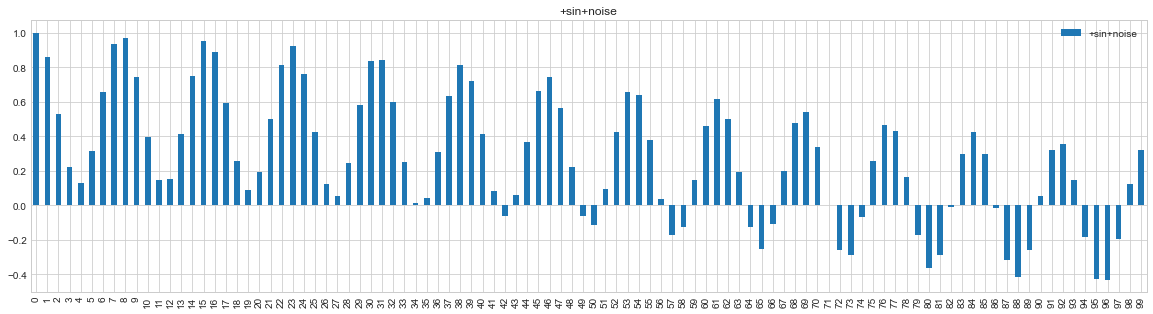

In [70]:
# コレラグラムで、自己相関係数を確認する
test = test[['+sin+noise']]
cols = test.columns
corr = pd.DataFrame(data={x: [test[x].autocorr(l) for l in range(24*7)] for x in cols})
corr[0:100].plot(kind='bar', subplots=True, figsize=(20, 5))

I recommend to set ns_h >= ncol_h and ns_t >= ncol_t


array([<AxesSubplot:xlabel='time'>, <AxesSubplot:xlabel='time'>,
       <AxesSubplot:xlabel='time'>, <AxesSubplot:xlabel='time'>,
       <AxesSubplot:xlabel='time'>, <AxesSubplot:xlabel='time'>],
      dtype=object)

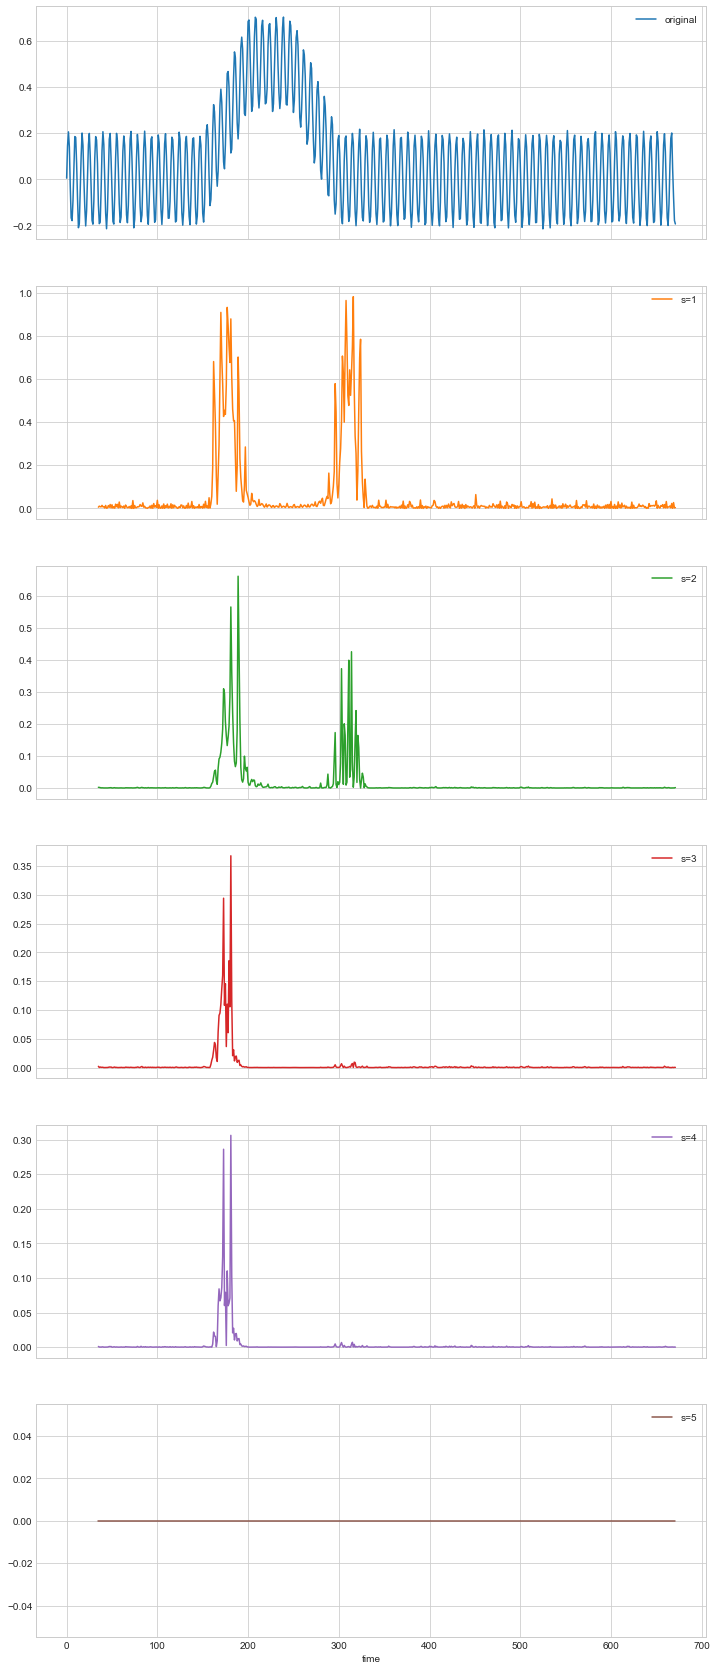

In [71]:
# 自己相関が12binの周期でありそうなので、打ち消すためにも、lagを24周期に設定して実行
sst = test.copy()
sst = sst[['+sin+noise']]
sst.rename(columns={'+sin+noise': 'original'}, inplace=True)
for s in range(1, 6):
    score = SSA_CD(series=sst['original'].values,
                   standardize=False,
                   w=8, lag=24, ns_h=s, ns_t=1)
    sst['s={}'.format(s)] = score[0]
sst.plot(subplots=True, figsize=(12, sst.shape[1] * 5))

I recommend to set ns_h >= ncol_h and ns_t >= ncol_t


array([<AxesSubplot:xlabel='time'>, <AxesSubplot:xlabel='time'>,
       <AxesSubplot:xlabel='time'>, <AxesSubplot:xlabel='time'>,
       <AxesSubplot:xlabel='time'>, <AxesSubplot:xlabel='time'>],
      dtype=object)

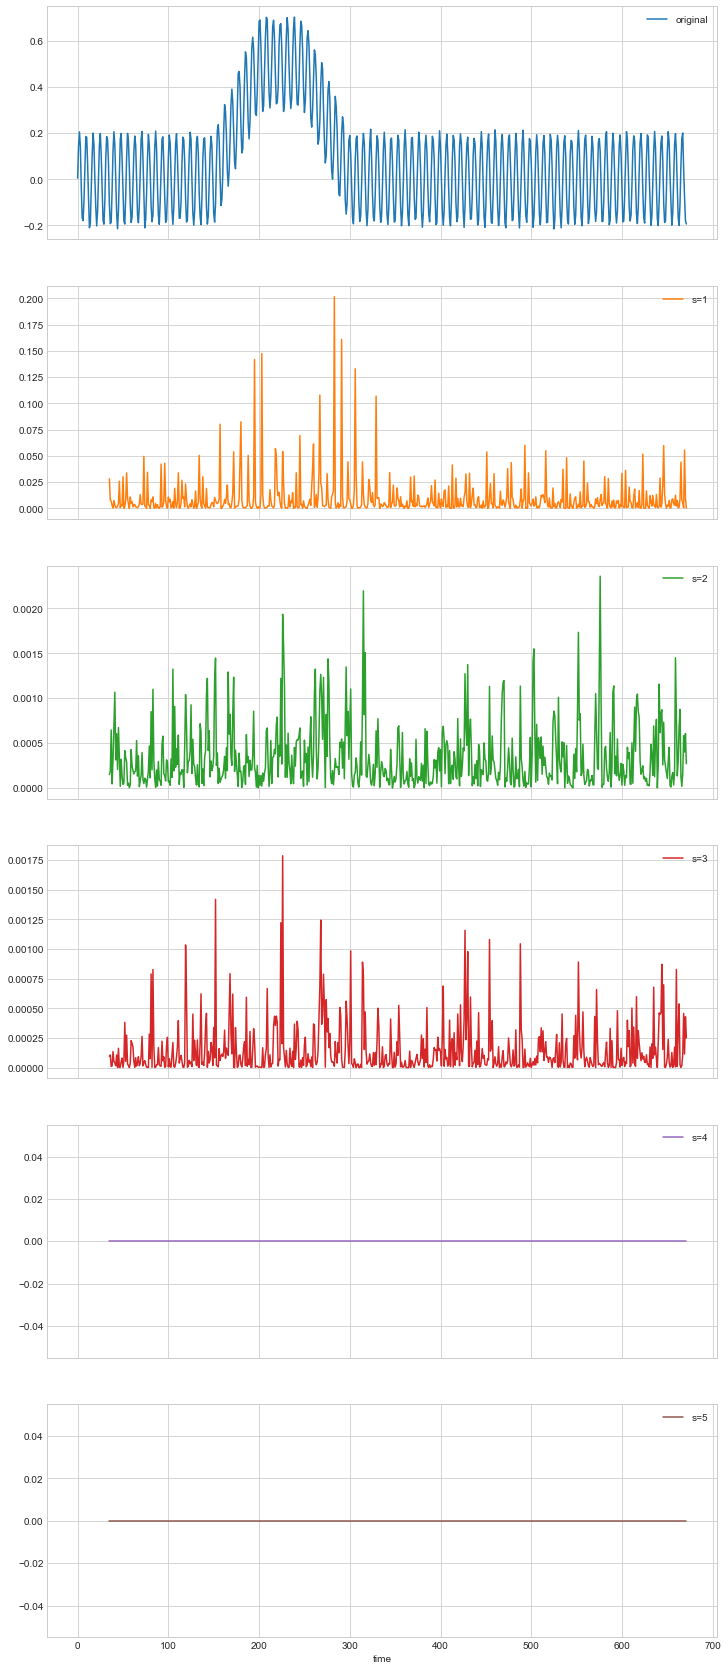

In [72]:
# 標準化で感度が向上している
# 時系列の上下シフトを除したためか、上方にシフトした201~250期中のノイズに対する感度が高くなっている
sst = test.copy()
sst = sst[['+sin+noise']]
sst.rename(columns={'+sin+noise': 'original'}, inplace=True)
for s in range(1, 6):
    score = SSA_CD(series=sst['original'].values,
                   standardize=False,
                   w=8, lag=24, ns_h=s, ns_t=1,
                   normalize=True)
    sst['s={}'.format(s)] = score[0]
sst.plot(subplots=True, figsize=(12, sst.shape[1] * 5))


# ECGデータで試してみる

In [73]:
path = "/Users/kushi/TechLife/free_dataset/ECG_data"
list_data = glob.glob(path + "/**.txt")
print(list_data)

['/Users/kushi/TechLife/free_dataset/ECG_data\\chfdb_chf01_275.txt', '/Users/kushi/TechLife/free_dataset/ECG_data\\chfdb_chf13_45590.txt', '/Users/kushi/TechLife/free_dataset/ECG_data\\ltstdb_20221_43.txt', '/Users/kushi/TechLife/free_dataset/ECG_data\\ltstdb_20321_240.txt', '/Users/kushi/TechLife/free_dataset/ECG_data\\mitdb__100_180.txt', '/Users/kushi/TechLife/free_dataset/ECG_data\\stdb_308_0.txt', '/Users/kushi/TechLife/free_dataset/ECG_data\\xmitdb_x108_0.txt']


In [74]:
df = pd.read_table(list_data[0], names=["time","s","ss"], sep='\t')
print(df.shape)
df.head()

(3751, 3)


,time,s,ss
0,275.000,-0.645,0.665
1,275.004,-0.635,0.710
2,275.008,-0.645,0.745
3,275.012,-0.635,0.760
4,275.016,-0.645,0.785


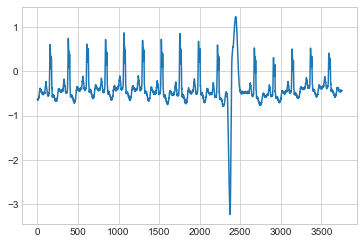

In [75]:
plt.plot(df["s"])

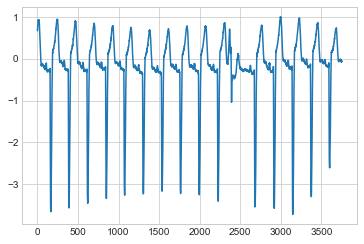

In [76]:
plt.plot(df["ss"])

array([<AxesSubplot:title={'center':'s'}>], dtype=object)

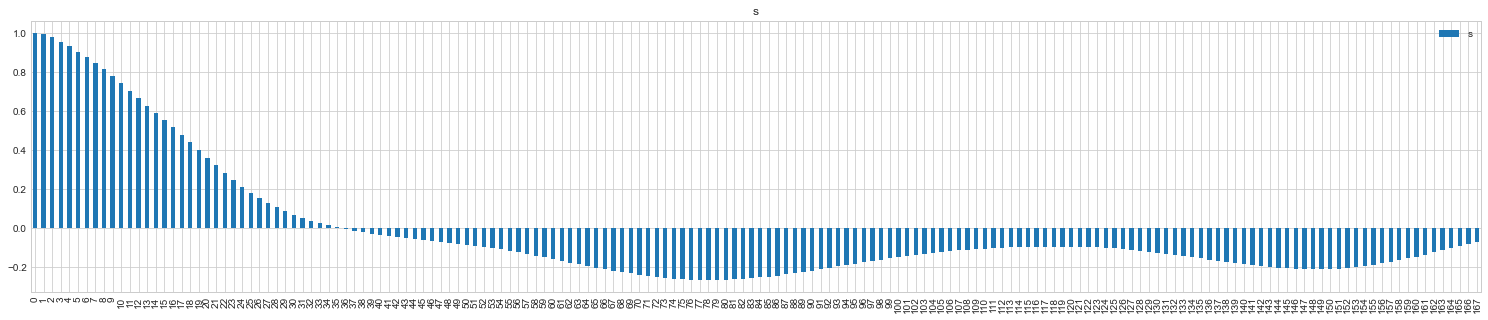

In [105]:
# コレラグラムで、自己相関係数を確認する
#test = test[['+sin+noise']]
#cols = test.columns

test_ecg = df[["s"]]
cols = test_ecg.columns
corr = pd.DataFrame(data={x: [test_ecg[x].autocorr(l) for l in range(24*7)] for x in cols})
corr[0:].plot(kind='bar', subplots=True, figsize=(26, 5))

(1301, 1)


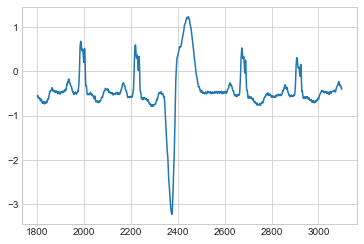

In [102]:
sst_ecg = test_ecg.copy()
sst_ecg = sst_ecg[['s']].loc[1800:3100]
print(sst_ecg.shape)
#sst_ecg.head()
plt.plot(sst_ecg)

Wall time: 2.8 s


array([<AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>,
       <AxesSubplot:>, <AxesSubplot:>], dtype=object)

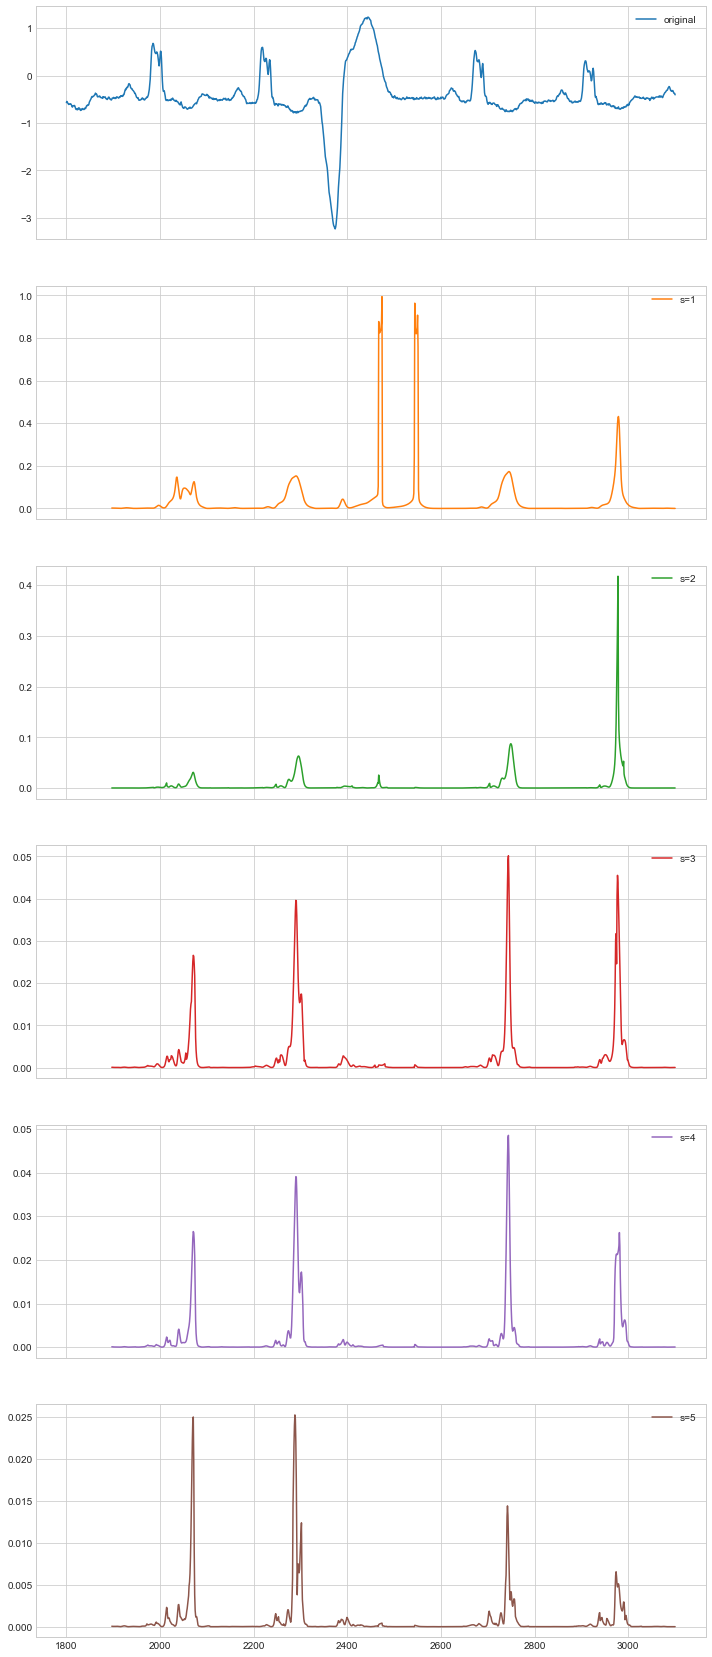

In [116]:
%%time
# 自己相関が12binの周期でありそうなので、打ち消すためにも、lagを24周期に設定して実行
#sst_ecg = test_ecg.copy()
#sst_ecg = sst_ecg[['s']]
sst_ecg.rename(columns={'s': 'original'}, inplace=True)
for s in range(1, 6):
     score = SSA_CD(series=sst_ecg['original'].values,
                    standardize=False,
                    w=60, lag=8, ns_h=s, ns_t=1)
        
     sst_ecg['s={}'.format(s)] = score[0]
    
sst_ecg.plot(subplots=True, figsize=(12, sst_ecg.shape[1] * 5))


In [92]:
print(sst.shape)
sst.head()

(3751, 1)


,original
0,-0.645
1,-0.635
2,-0.645
3,-0.635
4,-0.645


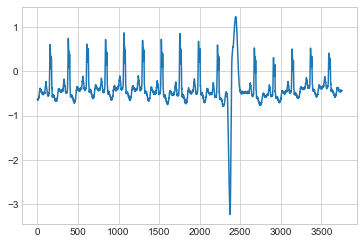

In [93]:
plt.plot(sst)